## Distribution Transfer using MLP

The aim of this notebook is to map samples from a normal distribution N(µ1,σ1) to samples from another normal distribution N(µ2,σ2) using MLP. This task could be done easily by direct computation and we will in fact use this to verify our networks.

At first, we will generate a dataset of samples from a normal distribution N(µ1,σ1) and we will construct their pair from the second distribution. This will allow us to train a MLP to have a first mapping.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data

np.random.seed(42)

### Dataset of paired gaussian distributions

In [2]:
class Paired_Gaussian_Dataset(data.Dataset):
    '''Generate a dataset of samples from a Gaussian N(µ1,σ1) 
       with their pair in another Gaussian N(µ2,σ2)'''
    
    def __init__(self, mu1, sigma1, mu2, sigma2, size):
        """
        Construct the datasets based on the parameters of the gaussians
        
        Parameters:
            mu1    -- mean of the first gaussian
            sigma1 -- standard deviation of the first gaussian
            mu2    -- mean of the second gaussian
            sigma2 -- standard deviation of the second gaussian
            size   -- size of the dataset
        """
        self.mu1 = mu1
        self.mu2 = mu2
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        
        # Generate samples from N(µ1,σ1) and compute their label - their pair in N(µ2,σ2)
        
        self.x = np.random.normal(mu1, sigma1, size)[:, np.newaxis]
        self.y = (self.x - mu1) / sigma1 * sigma2 + mu2
        
    def __len__(self):
        'Denotes the total number of samples'
        return self.x.shape[0]

    def __getitem__(self, index):
        '''
        Get one sample of data
        
        Parameter:
            index -- index of the sample in the dataset
            
        Return the sample in the first gaussian (x) and in the second gaussian (y)
        '''
        x = torch.from_numpy(self.x[index]).float()
        y = torch.from_numpy(self.y[index]).float()

        return x, y

In [3]:
# Definition of the parameters

mu1, sigma1 = 0, 1   # For N(µ1,σ1)
mu2, sigma2 = 10, 3   # For N(µ2,σ2)

train_size, test_size = 700, 300

params = {'batch_size': 32,
          'shuffle': True,
          'num_workers': 2}

# Instantiation of the train and test dataset

ds_train = Paired_Gaussian_Dataset(mu1, sigma1, mu2, sigma2, train_size)
dl_train = data.DataLoader(ds_train, **params)

ds_test = Paired_Gaussian_Dataset(mu1, sigma1, mu2, sigma2, test_size)
dl_test = data.DataLoader(ds_test, **params)

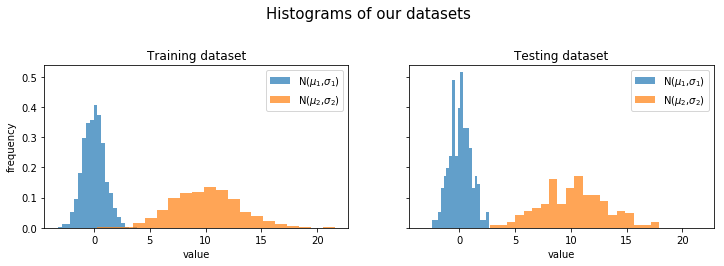

In [4]:
# Visualisation of our data

fig, ax = plt.subplots(1, 2, figsize=(12,3), sharex=True, sharey=True)

ax[0].hist(ds_train.x, bins=20, label=r'N($\mu_1$,$\sigma_1$)', alpha=0.7, density=True)
ax[0].hist(ds_train.y, bins=20, label=r'N($\mu_2$,$\sigma_2$)', alpha=0.7, density=True)
ax[0].set_xlabel('value')
ax[0].set_ylabel('frequency')
ax[0].legend(loc='best')
ax[0].set_title('Training dataset')

ax[1].hist(ds_test.x, bins=20, label=r'N($\mu_1$,$\sigma_1$)', alpha=0.7, density=True)
ax[1].hist(ds_test.y, bins=20, label=r'N($\mu_2$,$\sigma_2$)', alpha=0.7, density=True)
ax[1].set_xlabel('value')
ax[1].legend(loc='best')
ax[1].set_title('Testing dataset')

fig.suptitle("Histograms of our datasets", y=1.15, fontsize=15)
plt.show()

In [5]:
# Definition and instanciation of our network
class Network(nn.Module):
    
    def __init__(self):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(1, 25)
        self.fc2 = nn.Linear(25, 1)    
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)
    
net = Network()

In [6]:
# Define the loss function
criterion = nn.MSELoss()

In [7]:
# Define the optimizer
learning_rate = 1e-1
opt = torch.optim.SGD(net.parameters(), lr=learning_rate)

In [8]:
# Train our model
def train_model(model, crit, opt, dl_tr, dl_te, epochs):
    """
    Parameters :
        model  -- Containing parameters
        crit   -- Loss function
        opt    -- Optimisation function
        ds_tr  -- Training dataset
        ds_te  -- Testing dataset
        epochs -- Number of epochs
        
    Return arrays containing the train and test loss at each epoch
    """
    # Array to keep track of the train and test loss at each epoch
    loss_tr_values = []
    loss_te_values = []
    
    for ep in range(epochs):
        # Training mode
        model.train()
        
        # Variable to accumulate the train loss at one epoch
        loss_tr_run = 0
        
        # Loop for each batches
        for it, batch in enumerate(dl_tr):
            
            x, target = batch

            # Zero-out the accumulated gradients
            model.zero_grad()
            
            # Run forward pass
            output = model(x)
            
            # Compute the loss
            loss = crit(output, target)
            
            # Run backward pass
            loss.backward()
            
            # Update the weights using optimizer
            opt.step()
            
            loss_tr_run += loss
            
            print('\rEp {}/{}, it {}/{}: loss train: {:.2f}'.
                  format(ep + 1, epochs, it + 1, dl_tr.__len__(), loss_tr_run/(it+1)), end='')
        
        loss_tr = loss_tr_run / dl_tr.__len__()
        loss_tr_values.append(loss_tr)
        
        # Testing mode
        model.eval()
        with torch.no_grad():
            
            # Variable to accumulate the test loss at one epoch
            loss_te_run = 0
            
            for it, batch in enumerate(dl_te):
                x, target = batch
                
                # Get the output from the test samples through the trained network
                output_te = model(x)
                
                # Add the loss of the current batch
                loss_te_run += crit(output_te, target) 
                
            loss_te = loss_te_run / dl_te.__len__()
            loss_te_values.append(loss_te)
            print(', loss test: {:.2f}'.format(loss_te))
    
    return loss_tr_values, loss_te_values

In [9]:
epochs = 5
loss_tr_values, loss_te_values = train_model(net, criterion, opt, dl_train, dl_test, epochs)

Ep 1/5, it 22/22: loss train: 16.69, loss test: 1.01
Ep 2/5, it 22/22: loss train: 1.70, loss test: 0.01
Ep 3/5, it 22/22: loss train: 0.02, loss test: 0.00
Ep 4/5, it 22/22: loss train: 0.02, loss test: 0.00
Ep 5/5, it 22/22: loss train: 0.01, loss test: 0.00


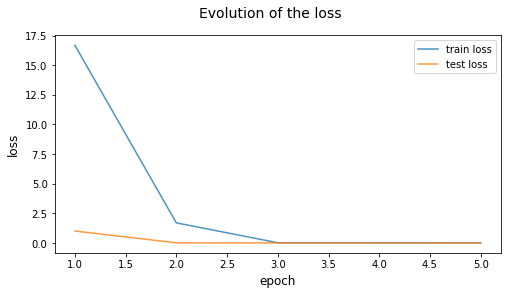

In [10]:
# Visualisation of the evolution of our train loss and test loss

fig, ax = plt.subplots(figsize=(8,4))

ax.plot(np.arange(epochs)+1, loss_tr_values, label='train loss', alpha=0.8)
ax.plot(np.arange(epochs)+1, loss_te_values, label='test loss', alpha=0.8)
ax.set_xlabel('epoch', labelpad=5, fontsize='large')
ax.set_ylabel('loss', labelpad=5, fontsize='large')
ax.legend(loc='best')

fig.suptitle('Evolution of the loss', fontsize=14)
plt.show()

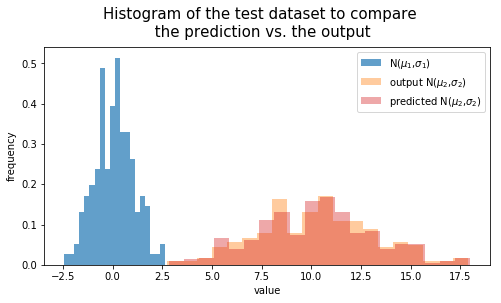

In [11]:
# Get the output from the test samples through the trained network

output_test = []
for it, batch in enumerate(dl_test):
    x, target = batch
    output_test_run = net(x).detach().numpy()
    for elem in output_test_run:
        output_test.append(elem.item())

# Visualisation of the output distribution vs. the target distribution of our test dataset        

fig, ax = plt.subplots(figsize=(8,4))

ax.hist(ds_test.x, bins=20, label=r'N($\mu_1$,$\sigma_1$)', alpha=0.7, density=True)
ax.hist(ds_test.y, bins=20, label=r'output N($\mu_2$,$\sigma_2$)', alpha=0.4, density=True)
ax.hist(output_test, bins=20, label=r'predicted N($\mu_2$,$\sigma_2$)', color='tab:red', alpha=0.4, density=True)
ax.set_xlabel('value')
ax.set_ylabel('frequency')
ax.legend(loc='best')

fig.suptitle("Histogram of the test dataset to compare\n the prediction vs. the output", fontsize=15, y = 1.02)
plt.show()